In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/1332faces.zip' -d '/content/imgData'

In [150]:
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import cm

In [151]:
def imgPilList(filePath):
  image_list = []
  for filename in glob.glob(filePath):
    im = Image.open(filename)
    image_list.append(im)
  return image_list

cwd = '/content/imgData/dataset'

filePath = cwd + "//0001-3000//*.jpg"
# filePath = cwd + "//6001-9000//*.jpg"
# filePath = cwd + "//9001-13322//*.jpg"

origin_img_data = imgPilList(filePath)

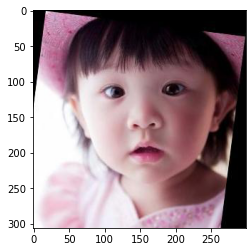

In [152]:
plt.imshow(origin_img_data[2])

In [153]:
standardize_image_shape = (64, 64)

def resizeImg(image, ideal_width, ideal_height):
    width  = image.size[0]
    height = image.size[1]
    aspect = width / float(height)
    ideal_aspect = ideal_width / float(ideal_height)
    if aspect > ideal_aspect:
      # Then crop the left and right edges:
      new_width = int(ideal_aspect * height)
      offset = (width - new_width) / 2
      resize = (offset, 0, width - offset, height)
    else:
      # ... crop the top and bottom:
      new_height = int(width / ideal_aspect)
      offset = (height - new_height) / 2
      resize = (0, offset, width, height - offset)
    thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
    return thumb
  
# 灰階轉換公式
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plot_gallery(title, images, n_col, n_row, cmap=plt.cm.gray, image_shape=standardize_image_shape):
    plt.figure(figsize=(2. * n_row, 2.26 * n_col))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

def standardized_img_list(imgList, idealImgShape):
  imgCollected = []
  width = idealImgShape[0]
  height = idealImgShape[1]
  for img in imgList:
    img = resizeImg(image = img, ideal_width = width, ideal_height = height)
    image_sequence = img.getdata()
    image_array = np.array(image_sequence)
    imgCollected.append(rgb2gray(image_array) / 255) # pixel between 0 ~ 1
  outputModel = np.array(imgCollected)
  return outputModel

def plotImgFromVector(vec, imgShape):
  shape_with = imgShape[0]
  shape_heigth = imgShape[1]
  resizeImg = np.reshape(vec, (shape_with, shape_heigth))
  outputModel = Image.fromarray(np.uint8(cm.gray(resizeImg)* 255))
  return outputModel
def extendComponent(vec):
  a = np.reshape(vec, (1, 4096))
  return np.dot(a.T, a)

In [154]:
standardized_img_data = standardized_img_list(origin_img_data, standardize_image_shape)

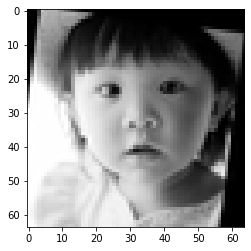

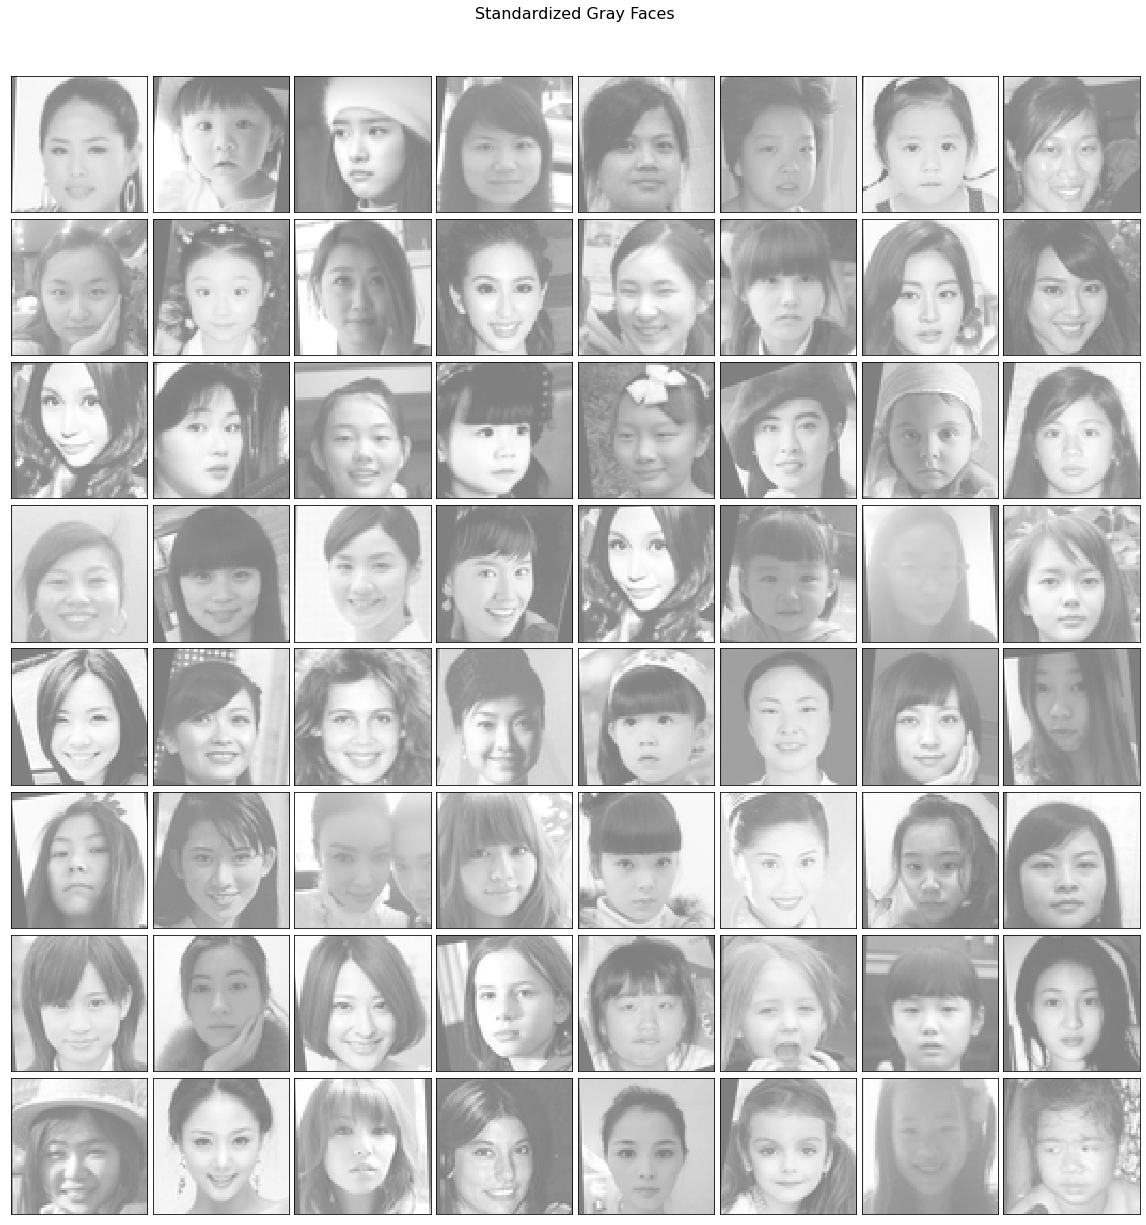

In [156]:
plotIndex = 1
n_col, n_row = 8, 8
im = plotImgFromVector(standardized_img_data[2], standardize_image_shape)
plt.imshow(im)
plot_gallery("Standardized Gray Faces", standardized_img_data[plotIndex:plotIndex + n_col * n_row], n_col = n_col, n_row = n_row)

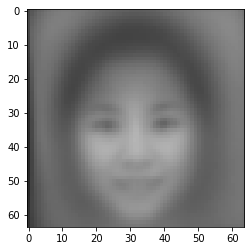

In [157]:
meanFace = np.mean(standardized_img_data, axis=0)
plt.imshow(plotImgFromVector(meanFace, standardize_image_shape))

# PCA

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [158]:
from sklearn.decomposition import PCA
from time import time

In [159]:
# size = (w, h)
origin_img_size = (64, 64)
pca_img_size = (16, 16)
n_components = pca_img_size[0] * pca_img_size[1]

In [160]:
trainX = standardized_img_data - np.tile(meanFace, (3000, 1))
n_samples = trainX.shape[0]
print("trainX shape", trainX.shape)
print("Extracting the top %d eigenfaces from %d faces" % (n_components, trainX.shape[0]))

trainX shape (3000, 4096)
Extracting the top 256 eigenfaces from 3000 faces


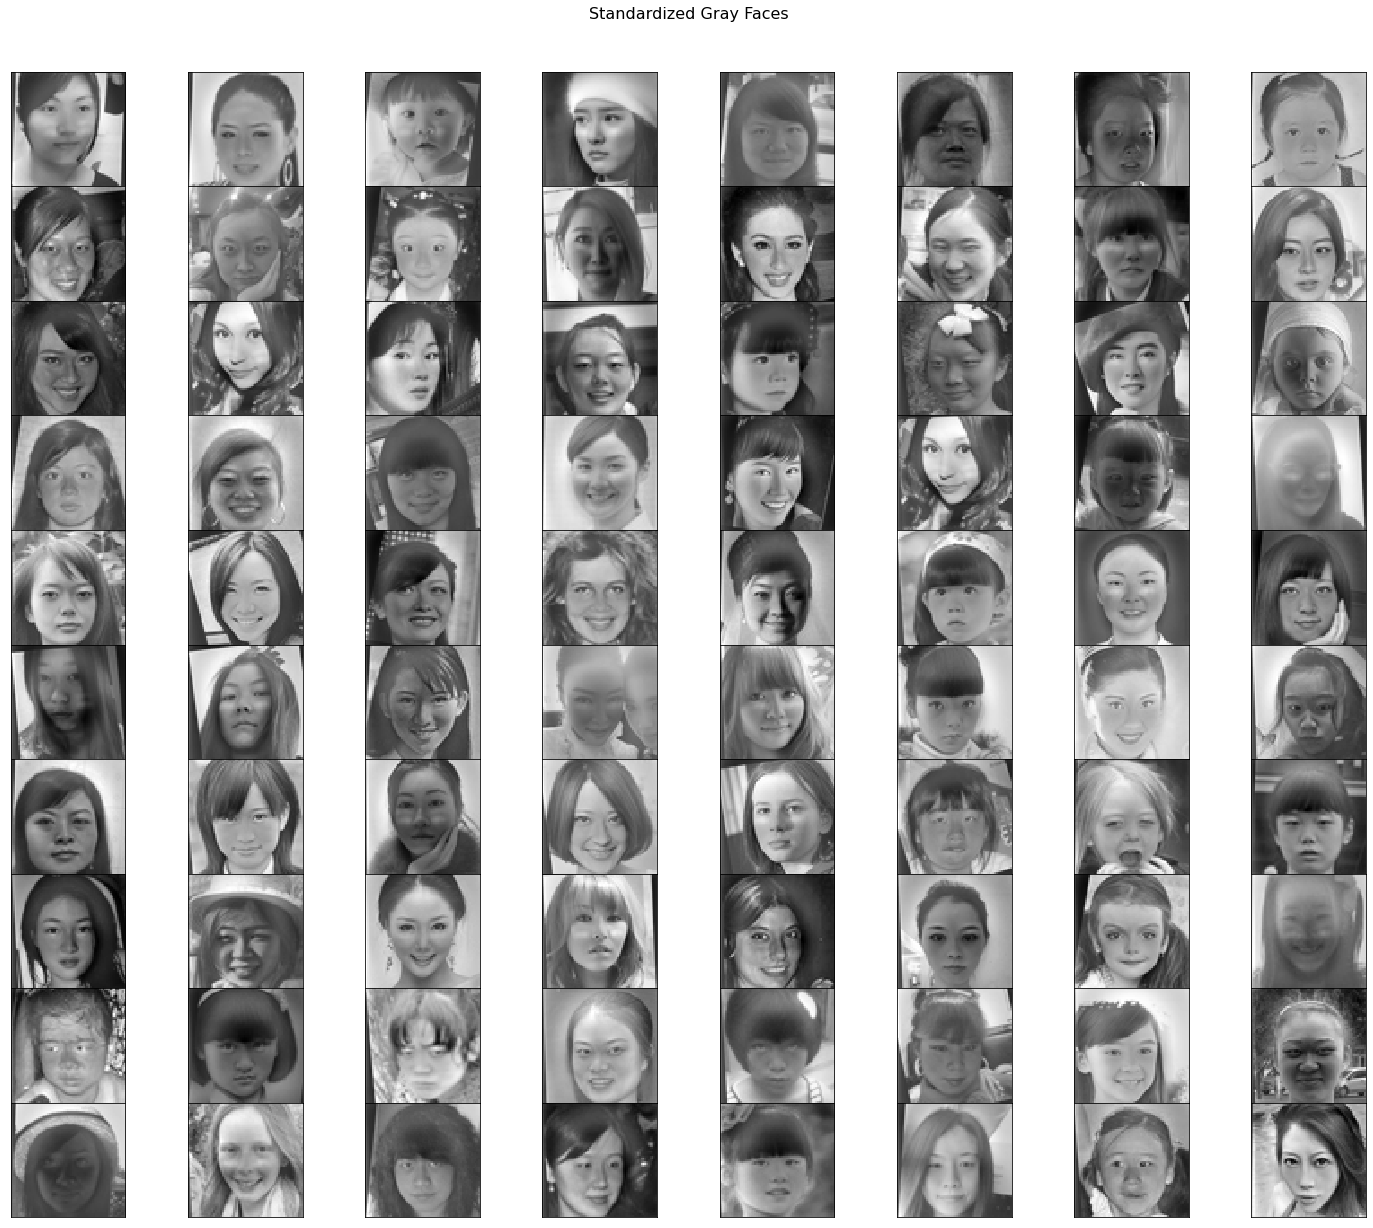

In [204]:
plotIndex = 0
n_col, n_row = 8, 10
plot_gallery("Standardized Gray Faces", trainX[plotIndex:plotIndex + n_col * n_row], n_col = n_col, n_row = n_row)

Simple PCA

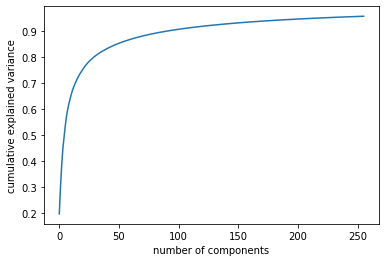

In [175]:
#進行降維
pca = PCA(n_components=n_components).fit(trainX)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Projecting the input data on the eigenfaces orthonormal basis
component size (256, 4096)
(256, 64, 64)


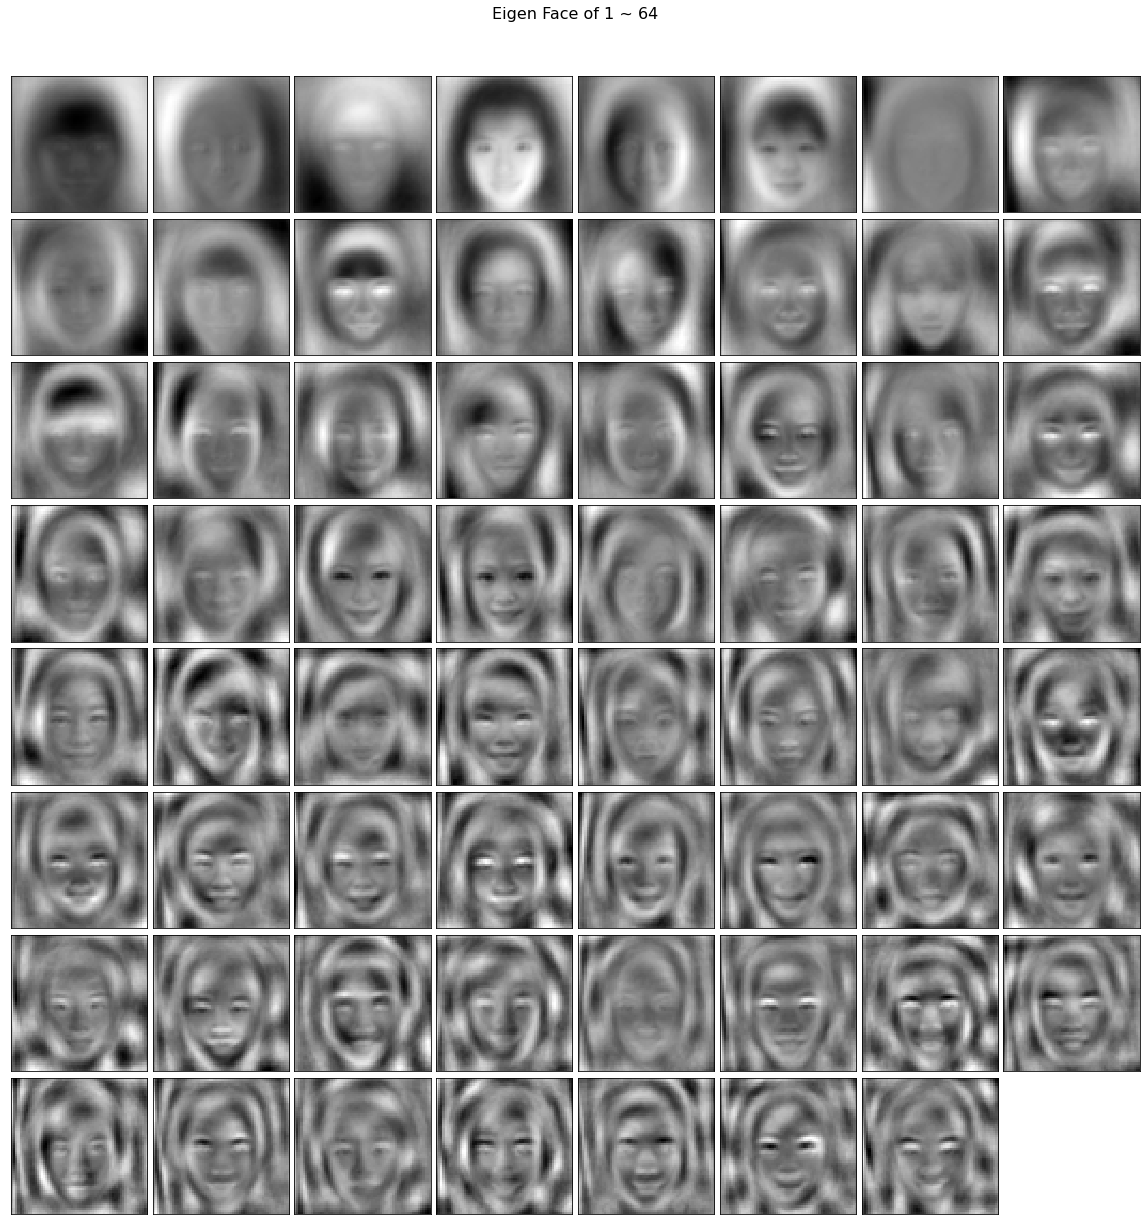

In [176]:
print("Projecting the input data on the eigenfaces orthonormal basis")
print("component size", pca.components_.shape)
eigenfaces = pca.components_.reshape((n_components, origin_img_size[0], origin_img_size[1]))

print(eigenfaces.shape)
pltX = 8
pltY = 8
plot_gallery("Eigen Face of 1 ~ " + str(pltX * pltY), eigenfaces[1:pltX * pltY], pltX, pltY)

(1, 1)
(1, 4096)
(4096,)
(1, 4096)
(4096,)


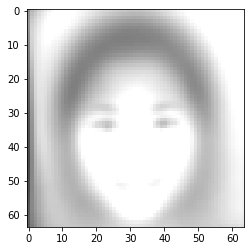

In [216]:
# component

mat = np.tile(meanFace, (3000, 1))
test = np.dot(trainX[0].reshape(1, 4096), pca.components_[0].reshape(4096, 1))
print(test.shape)
arr = mat[0] + test * pca.components_[0]
print(arr.shape)
print(meanFace.shape)
im = plotImgFromVector(arr + meanFace.reshape(1, 4096), (64,64))
plt.imshow(im)

pca components (256, 4096)
[3.19220068]


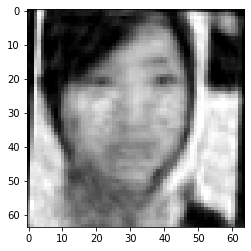

In [226]:
print("pca components", pca.components_.shape)

im = trainX[0]
reconstructIm = []
for i in range(len(pca.components_)):
  reconstructIm.append(np.dot(trainX[0].reshape(1, 4096), pca.components_[i].reshape(4096, 1)))

img1 = meanFace
for i in range(len(pca.components_)):
  img1 += pca.components_[i] * reconstructIm[i][0]

plt.imshow( plotImgFromVector(img1, (64, 64)))

In [198]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import cluster
import sys


[0 9 9 1 7 2 7 3 8 5 8 4 8 9 2 7 2 1 8 8 2 8 8 7 5 6 2 3 8 1 2 6 5 9 7 5 0
 4 1 8 2 4 4 6 7 3 3 9 7 5 4 5 1 0 1 2 2 4 3 7 8 3 5 4 0 2 6 1 0 4 6 8 4 6
 2 8 0 5 5 9 1 2 5 1 0 9 7 8 1 7 8 3 1 8 1 4 9 5 7 7 1 2 1 3 3 5 6 8 4 5 8
 6 8 6 8 7 1 2 6 0 1 7 8 3 1 6 3 1 8 1 2 5 0 9 4 5 9 5 4 5 1 6 3 4 6 6 8 5
 3 3 8 3 3 7 1 1 3 4 7 9 7 1 4 1 5 2 5 8 8 8 2 7 5 8 2 1 2 1 7 1 5 2 9 1 8
 2 6 3 2 3 0 2 1 9 1 0 8 4 6 2 8 0 6 3 9 0 5 1 0 6 1 9 2 1 7 4 0 8 8 6 4 0
 8 0 5 2 2 1 9 8 2 7 4 8 5 6 7 7 4 0 3 2 2 1 4 0 9 4 8 2 3 5 5 1 6 0 5 3 8
 3 1 8 2 6 2 8 0 8 8 1 5 5 1 0 1 8 7 3 0 7 5 3 2 5 4 4 7 0 2 1 4 1 2 6 1 1
 3 3 7 0 7 8 9 3 0 6 0 5 4 5 3 9 5 4 8 9 8 9 5 4 1 7 5 8 8 1 0 7 2 8 2 7 5
 0 0 7 5 7 4 2 8 1 4 0 1 3 1 5 7 9 5 8 8 2 5 5 3 7 4 2 1 1 8 2 2 4 0 7 9 6
 0 7 0 0 2 9 1 8 1 2 0 8 2 7 3 0 1 2 9 3 4 5 1 5 0 3 1 5 0 9 1 1 8 4 5 2 9
 5 9 1 2 0 7 1 8 8 4 8 8 8 9 6 7 0 5 9 2 1 1 5 2 2 3 8 4 5 9 2 2 0 1 2 0 8
 6 4 7 4 9 4 4 3 2 8 4 8 9 6 5 7 6 0 8 5 7 9 1 7 0 9 0 2 4 2 0 9 4 5 2 1 9
 0 2 2 1 4 2 2 9 9 5 9 6 

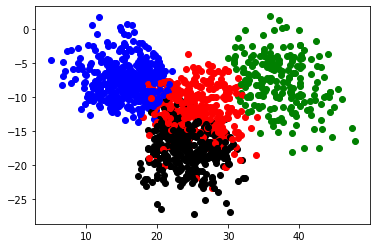

In [206]:
data = X_train_pca
estimator = KMeans(n_clusters=10)
res=estimator.fit_predict(data)
lable_pred=estimator.labels_
centroids=estimator.cluster_centers_
inertia=estimator.inertia_

np.set_printoptions(threshold=sys.maxsize)
print(lable_pred)
# print(centroids)

for i in range(len(data)):
  if int(lable_pred[i])==0:
    plt.scatter(data[i][0],data[i][1],color='red')
  if int(lable_pred[i])==1:
    plt.scatter(data[i][0],data[i][1],color='black')
  if int(lable_pred[i])==2:
    plt.scatter(data[i][0],data[i][1],color='blue')
  if int(lable_pred[i])==3:
    plt.scatter(data[i][0],data[i][1],color='green')
plt.show()

In [ ]:
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time
import logging

In [ ]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,random_state=RandomState(0))
faces = trainFaces

n_samples, n_features = faces.shape
print(faces.shape)

(3000, 4096)


In [ ]:
# global centering
faces_centered = faces - faces.mean(axis=0)

In [ ]:
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 3000 faces


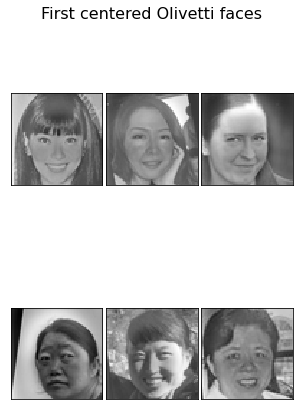

In [ ]:
plot_gallery("First centered Olivetti faces", faces_centered[:n_components], n_col, n_row)

In [ ]:
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=20),
     True),
]

Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.707s
Extracting the top 6 Non-negative components - NMF...
done in 6.090s
Extracting the top 6 Independent components - FastICA...
done in 26.475s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 4.264s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 1.443s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.481s
Extracting the top 6 Factor Analysis components - FA...
done in 2.364s


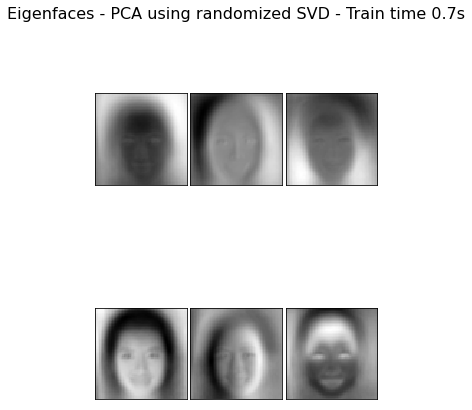

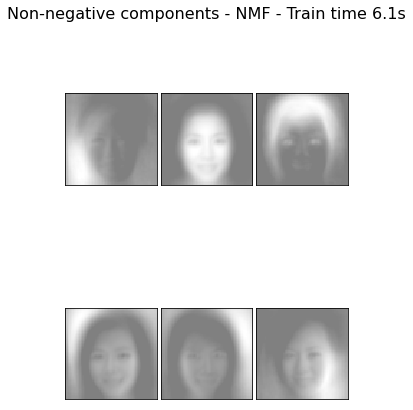

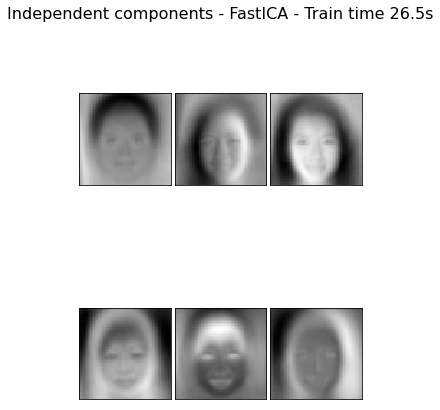

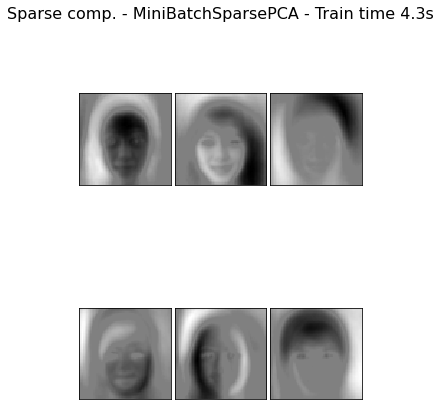

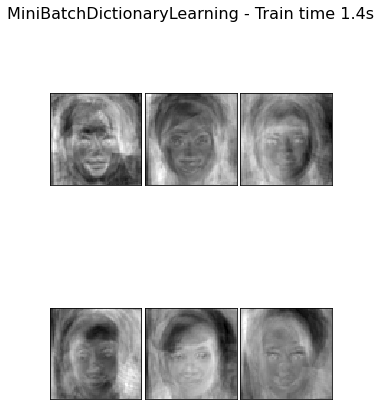

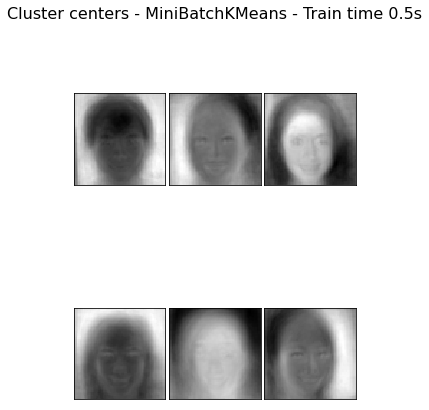

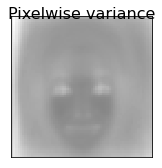

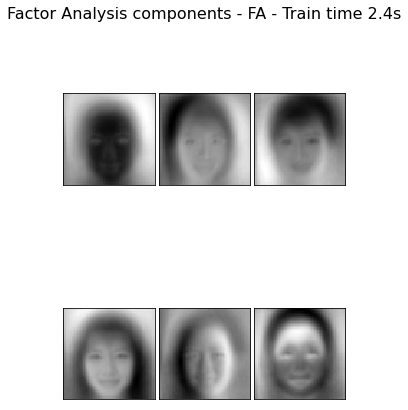

In [ ]:
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components], 3, 2)

plt.show()

In [ ]:
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    #('Dictionary learning - positive code',
    #    decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
    #                                              n_iter=50, batch_size=3,
    #                                              fit_algorithm='cd',
    #                                              random_state=rng,
    #                                              positive_code=True),
    # True),
    # ('Dictionary learning - positive dictionary & code',
    #     decomposition.MiniBatchDfictionaryLearning(n_components=15, alpha=0.1,
    #                                                n_iter=50, batch_size=3,
    #                                                fit_algorithm='cd',
    #                                                random_state=rng,
    #                                                positive_dict=True,
    #                                                positive_code=True),
    #  True),
]

Extracting the top 6 Dictionary learning...
done in 1.492s
Extracting the top 6 Dictionary learning - positive dictionary...
done in 1.473s


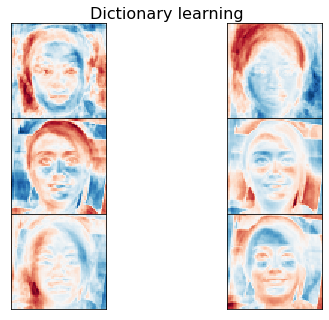

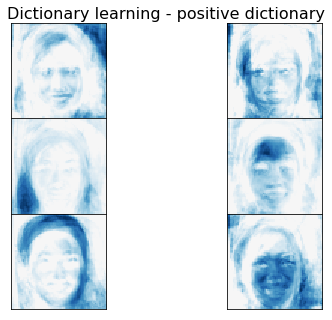

In [ ]:
for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], 2, 3, cmap=plt.cm.RdBu)

plt.show()

In [ ]:
print(trainFaces.shape[0])

3000


# 臉部分群

https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/

In [ ]:
# DBSCAN 
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [ ]:
X = X_train_pca
print(X)

[[ 0.24876909  0.19811043 -1.10404842 ...  1.78281979 -0.96606367
   0.81441944]
 [-0.88333208 -0.17582101  1.10658406 ...  0.38178417 -1.22547932
  -1.93259374]
 [-1.07949183 -1.23642981 -0.00284667 ... -0.33502849  0.70704757
  -0.13544233]
 ...
 [ 0.47829354  0.84515976 -0.80192467 ... -0.10012481 -1.32632235
  -0.51031072]
 [ 2.10597432 -0.42128078 -1.68623116 ... -0.10978389 -0.59842846
  -0.76566432]
 [-1.36160433  0.21990299  0.75267773 ... -0.51455287  1.09381268
   0.60908753]]


In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 3000


NameError: ignored

In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)


In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Chinese-Whisper分類演算法

https://www.itread01.com/content/1544826095.html
Library: https://github.com/nlpub/chinese-whispers-python

In [ ]:
import networkx as nx
from chinese_whispers import chinese_whispers, aggregate_clusters
import matplotlib as plt

In [ ]:
# chinese_whispers(G, weighting='top', iterations=20)
G = nx.karate_club_graph()

# Perform clustering of G, parameters weighting and seed can be omitted
chinese_whispers(G, weighting='top', seed=1337) 

# Print the clusters in the descending order of size
print('ID\tCluster\n')

for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))



AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

colors = [1. / G.nodes[node]['label'] for node in G.nodes()]

nx.draw_networkx(G, cmap=plt.get_cmap('jet'), node_color=colors, font_color='white')

KeyError: ignored